In [2]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from standardization_process import plot_reg_correlation,plot_diagram,unreliable_datapoints,plot_cls_correlation,identify_unreliable_group,final_mean_value
from data_split import train_test_split

In [4]:
def remove_bad_datapoints(df,controlled_list,value_col,fold=np.log10(3)):
    bad_datapoints_index = unreliable_datapoints(df, controlled_list, value_col)
    df = df.loc[~df.index.isin(bad_datapoints_index),] 
    
    bad_group_index = identify_unreliable_group(df, controlled_list, value_col, fold=fold)
    
    df = df.loc[~df.index.isin(bad_group_index),] 
    
    
    return df

In [5]:
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
def compound_property_analysis(mol_list):
    atom_counts = mol_list.map(lambda x: x.GetNumAtoms())
    qed = mol_list.parallel_apply(Descriptors.qed)
    logp = mol_list.parallel_apply(Descriptors.MolLogP)
    TPSA = mol_list.parallel_apply(Descriptors.TPSA)
    HBD = mol_list.parallel_apply(Descriptors.NumHDonors)
    HBA = mol_list.parallel_apply(Descriptors.NumHAcceptors)
    
    fig, axs = plt.subplots(3,2, figsize=(16, 10))

    # Plot data
    axs[0, 0].hist(qed, bins=20, color='b', alpha=0.7, label='A')
    axs[0, 0].set_title('qed')

    axs[0, 1].hist(atom_counts, bins=20, color='r', alpha=0.7, label='B')
    axs[0, 1].set_title('atom_counts')

    axs[1, 0].hist(logp, bins=20, color='g', alpha=0.7, label='C')
    axs[1, 0].set_title('logp')

    axs[1, 1].hist(TPSA, bins=20, color='y', alpha=0.7, label='D')
    axs[1, 1].set_title('TPSA')

    axs[2, 0].hist(HBD, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 0].set_title('HBD')

    axs[2, 1].hist(HBA, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 1].set_title('HBA')

    # Add some labels and titles for better readability
    for ax in axs.flat:
        ax.set( ylabel='Frequency')


    plt.show()

# Load data

In [6]:
all_data = pd.read_csv('../data/data_processing_result/microsomal_cl_preprocessing_finished.csv')

In [7]:
all_data.head()

,Smiles_unify,Smiles,value,unit,species,conc,Presence of NADPH/NADP,source
0,C[C@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)...,C[C@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)...,1.886491,log10(mL.min-1.g-1),human,1 uM,none,CHEMBL928910
1,C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4nccs4)c3)...,C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4nccs4)c3)...,1.146128,log10(mL.min-1.g-1),rat,1 uM,none,CHEMBL928911
2,C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4cscn4)c3)...,C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4cscn4)c3)...,1.255273,log10(mL.min-1.g-1),rat,1 uM,none,CHEMBL928911
3,CCCCNC(=O)c1ccc2c(c1)N=C(c1ccc(Cl)cc1)c1ccccc1S2,CCCCNC(=O)c1ccc2c(c1)N=C(c1ccc(Cl)cc1)c1ccccc1S2,1.949390,log10(mL.min-1.g-1),rat,none,none,CHEMBL1002992
4,Cc1cc(SCc2cc(=O)[nH][nH]2)c(C)cc1Cl,Cc1cc(SCc2cc(=O)[nH][nH]2)c(C)cc1Cl,2.383815,log10(mL.min-1.g-1),mouse,in presence of NADPH,mouse microsome,CHEMBL1645623


<AxesSubplot:>

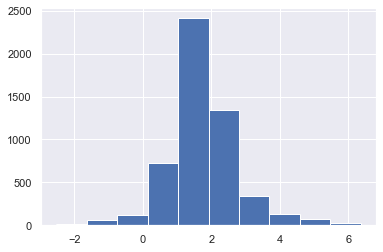

In [8]:
all_data['value'].hist()

### Repeated values

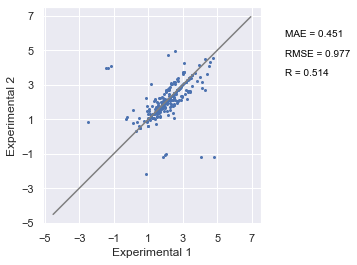

In [9]:
plot_diagram(all_data, ['Smiles_unify','species','conc'], 'value')

# Further filtering

In [10]:
df_remove_bad_data = remove_bad_datapoints(all_data,['Smiles_unify','species'],'value',fold=np.log10(3))

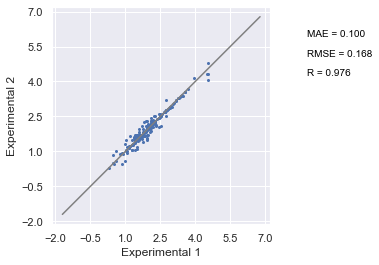

In [11]:
plot_diagram(df_remove_bad_data,['Smiles_unify','species'], 'value')

# Different Speices Microsomal Clearance

In [12]:
df_remove_bad_data['species'].value_counts()

human    2379
mouse    1447
rat      1215
Name: species, dtype: int64

In [15]:
df_remove_bad_data= df_remove_bad_data[['Smiles_unify','value','species']]

In [16]:
human = df_remove_bad_data[df_remove_bad_data['species'] == 'human']
mouse = df_remove_bad_data[df_remove_bad_data['species'] == 'mouse']
rat = df_remove_bad_data[df_remove_bad_data['species'] == 'rat']

In [17]:
human = final_mean_value(human,['Smiles_unify'], 'value')
mouse = final_mean_value(mouse,['Smiles_unify'], 'value')
rat = final_mean_value(rat,['Smiles_unify'], 'value')

In [18]:
human['value'] = human['value_mean'].copy()
mouse['value'] = mouse['value_mean'].copy()
rat['value'] = rat['value_mean'].copy()

In [19]:
human = human.drop_duplicates('Smiles_unify')
mouse = mouse.drop_duplicates('Smiles_unify')
rat = rat.drop_duplicates('Smiles_unify')

In [20]:
human

,Smiles_unify,value,species,value_mean
0,C[C@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)...,1.886491,human,1.886491
14,Cc1ccc2c(OCCN3CCC(Cc4cccc(N5CCN(C)CC5)c4)CC3)c...,0.204120,human,0.204120
16,Cc1cc(Nc2cc(C)c(C#N)c(N[C@@H](C)CCCC(C)(C)O)n2...,1.698970,human,1.698970
25,C[C@@H]1CC[C@H](N)CN1c1ccncc1Nc1ncc2ccc(-c3c(F...,2.307496,human,2.307496
29,Cc1cc(C)c(S(=O)(=O)N[C@@H](C)CNc2cccc3c2cnn3-c...,1.892095,human,1.892095
...,...,...,...,...
5233,CCn1c(=O)[nH]c(=O)c2c1nc(Cc1nc3ccccc3[nH]1)n2C...,2.767156,human,2.767156
5235,COc1ccc(CN2CCC[C@H](OCc3ccc(F)c(F)c3)C2)cc1F,2.435367,human,2.435367
5239,COc1ccc(/N=C(\N)CC(O)c2cc3c(F)cc(F)cc3c3cc(C(F...,0.954243,human,0.954243
5250,CCOc1ccc(F)cc1NC(=O)c1cc(C)ccc1NS(=O)(=O)CC,1.840733,human,1.840733


In [21]:
human['property'] = 'human_mic_cl'
rat['property'] = 'rat_mic_cl'
mouse['property'] = 'mouse_mic_cl'

In [22]:
human = human[['Smiles_unify','value','property']]
rat = rat[['Smiles_unify','value','property']]
mouse = mouse[['Smiles_unify','value','property']]



# Compound Property analysis

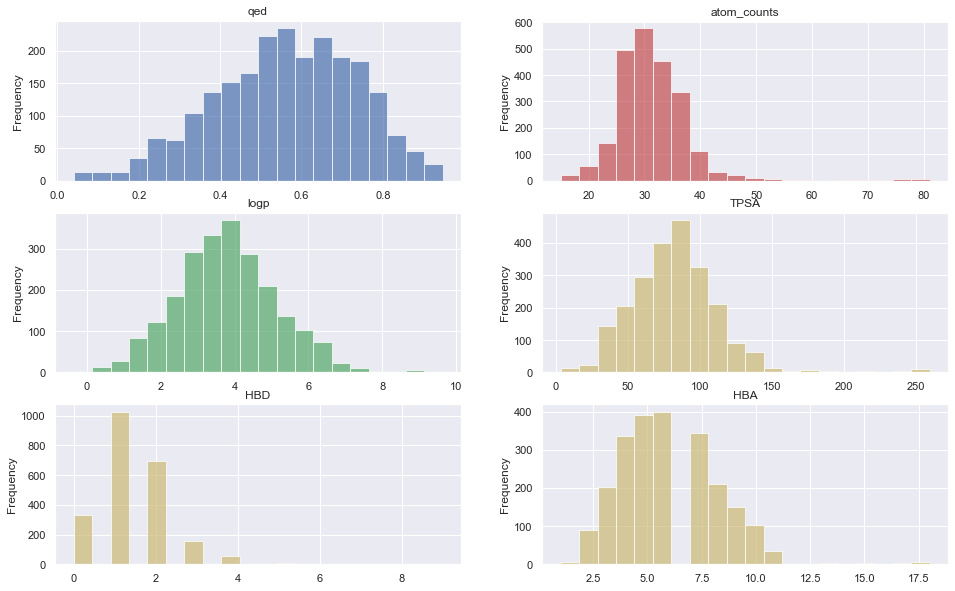

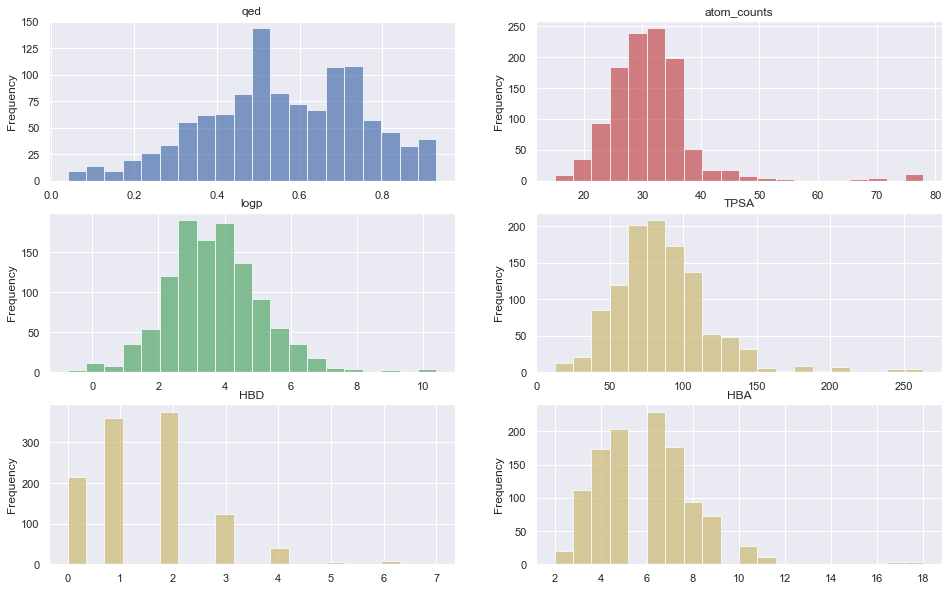

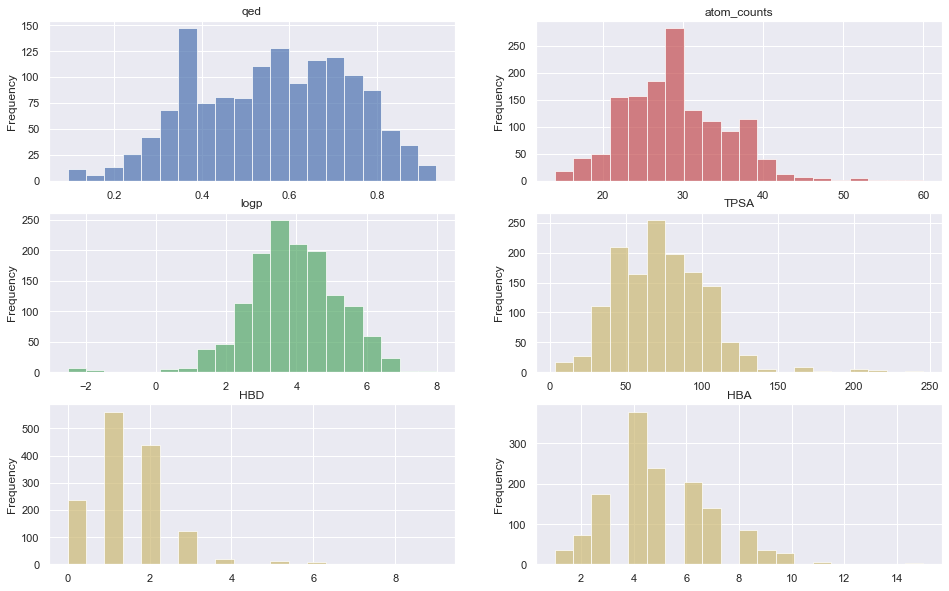

In [23]:
    
for spec in [human,rat,mouse]:

    mol_list = spec['Smiles_unify'].map(Chem.MolFromSmiles)
    compound_property_analysis(mol_list)

# Data Split

In [24]:
human = human.reset_index()

In [25]:
train_index,test_index = train_test_split(human['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
human.loc[train_index,'scaffold_train_test_label'] = 'train'
human.loc[test_index,'scaffold_train_test_label'] = 'test'

train_index,test_index = train_test_split(human['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
human.loc[train_index,'random_train_test_label'] = 'train'
human.loc[test_index,'random_train_test_label'] = 'test'

100%|█████████████████████████████████████| 2286/2286 [00:00<00:00, 8735.96it/s]


In [26]:
human.to_csv('../data/final_datasets/hum_mic_cl_reg_final_data.csv')

In [27]:
rat = rat.reset_index()

In [28]:
train_index,test_index = train_test_split(rat['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
rat.loc[train_index,'scaffold_train_test_label'] = 'train'
rat.loc[test_index,'scaffold_train_test_label'] = 'test'

train_index,test_index = train_test_split(rat['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
rat.loc[train_index,'random_train_test_label'] = 'train'
rat.loc[test_index,'random_train_test_label'] = 'test'

100%|█████████████████████████████████████| 1129/1129 [00:00<00:00, 8403.17it/s]


In [29]:
rat.to_csv('../data/final_datasets/rat_mic_cl_reg_final_data.csv')

In [30]:
mouse = mouse.reset_index()

In [31]:
train_index,test_index = train_test_split(mouse['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
mouse.loc[train_index,'scaffold_train_test_label'] = 'train'
mouse.loc[test_index,'scaffold_train_test_label'] = 'test'

train_index,test_index = train_test_split(mouse['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
mouse.loc[train_index,'random_train_test_label'] = 'train'
mouse.loc[test_index,'random_train_test_label'] = 'test'

100%|█████████████████████████████████████| 1403/1403 [00:00<00:00, 6630.40it/s]


In [32]:
mouse.to_csv('../data/final_datasets/mou_mic_cl_reg_final_data.csv')